# GO Game outcome prediction

### Principle

A GO player who is able to tell if a board is a winning board or a losing board should be a good player: He would simply have to chose the move that will bring him the most winning board.

### Content

This code produces a neural network that learns what is and what is not a winning board, by seeing 41563 GO game boards. It tries to predict the probability with which the blacks win.

### Getting raw data

In [1]:
import gzip
import json

#Training set
with gzip.open("samples-9x9.json.gz") as fz:
    dataset = json.loads(fz.read().decode("utf-8"))

#Testing set
with gzip.open("positions-to-evaluate-9x9-attempt.json.gz") as fz2:
    testing_set = json.loads(fz2.read().decode("utf-8"))
    
#Testing set results
with open("positions-to-evaluate-9x9-attempt.results.txt", "r") as f:
    testing_set_res = [float(line.strip()) for line in f if line]

### Visualize dataset

In [2]:
def summary_of_example(training_set, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = dataset[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Raw JSON data:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

summary_of_example(dataset,10)

Sample 10

Raw JSON data: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games


### Processing data - X_train, y_train, X_test, y_test

In [3]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

#Building X_train
X_train = np.zeros([len(dataset),9,9,2])
i = 0
for sample in dataset:
    for move in sample["black_stones"]:
        coord = name_to_coord(move)
        X_train[i][coord][0] = 1
    for move in sample["white_stones"]:
        coord = name_to_coord(move)
        X_train[i][coord][1] = 1
    i+=1

#Building y_train
y_train = np.zeros([len(dataset)])
for k in range(len(dataset)):
    y_train[k] = dataset[k]["black_wins"]/dataset[k]["rollouts"]
    
#Building X_test
X_test = np.zeros([len(testing_set),9,9,2])
i = 0
for sample in testing_set:
    for move in sample["black_stones"]:
        coord = name_to_coord(move)
        X_test[i][coord][0] = 1
    for move in sample["white_stones"]:
        coord = name_to_coord(move)
        X_test[i][coord][1] = 1
    i+=1

#Building y_test
y_test = testing_set_res

### Building the neural network

In [4]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import History
import matplotlib
import matplotlib.pyplot as plt


model = Sequential()
model.add(Conv2D(16,5,activation='relu',padding='same',input_shape=(9, 9, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))
model.add(Conv2D(1,3,activation='relu',padding='same',data_format="channels_last",input_shape=(9, 9, 2)))
model.add(Flatten())
model.add(Dense(50))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss = 'mean_squared_error',
                 optimizer = optimizers.RMSprop(lr=0.0005),
                 metrics = ['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 16)          816       
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 16)          64        
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 16)          0         
_________________________________________________________________
activation (Activation)      (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 1)           145       
_________________________________________________________________
flatten (Flatten)            (None, 81)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                4

### Training the network

In [5]:
history = model.fit(X_train, y_train, validation_split = 0.4,
         batch_size = 128,
         epochs = 48,
         verbose = 1)

Epoch 1/48
195/195 [==============================] - 4s 22ms/step - loss: 0.1177 - mae: 0.2789 - val_loss: 0.1346 - val_mae: 0.3239
Epoch 2/48
195/195 [==============================] - 1s 4ms/step - loss: 0.0994 - mae: 0.2531 - val_loss: 0.1230 - val_mae: 0.3083
Epoch 3/48
195/195 [==============================] - 1s 4ms/step - loss: 0.0923 - mae: 0.2414 - val_loss: 0.0935 - val_mae: 0.2552
Epoch 4/48
195/195 [==============================] - 1s 4ms/step - loss: 0.0878 - mae: 0.2338 - val_loss: 0.0851 - val_mae: 0.2361
Epoch 5/48
195/195 [==============================] - 1s 4ms/step - loss: 0.0833 - mae: 0.2269 - val_loss: 0.0803 - val_mae: 0.2228
Epoch 6/48
195/195 [==============================] - 1s 4ms/step - loss: 0.0809 - mae: 0.2227 - val_loss: 0.0877 - val_mae: 0.2438
Epoch 7/48
195/195 [==============================] - 1s 4ms/step - loss: 0.0788 - mae: 0.2197 - val_loss: 0.0764 - val_mae: 0.2115
Epoch 8/48
195/195 [==============================] - 1s 4ms/step - loss: 0

### Visualize loss

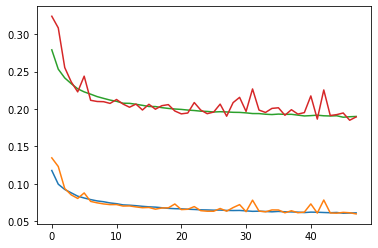

In [6]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.show()

### Predict 

In [9]:
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error
print("MSE on the testing set:",mean_squared_error(y_test,predictions))

MSE on the testing set: 0.06289741200349251


-> We get a model that is able to predict the outcome of a GO Game with a tiny error, just by seeing the board.